In [82]:
import pandas as pd
from pathlib import Path
import time
from tqdm.notebook import tqdm
import numpy as np
import neptune
import datetime

In [83]:
args = {}
args['data_folder'] = './Data'
args['data_filename'] = 'full_data_2014to2021.pkl'
args['summarize_n_games']= 10
args['columns_to_summarize']=['Pace', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'ORtg', 'TS%', 
                              '3PAr', 'FTr', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'DRtg']
args['summarize_method']='mean'
args['columns_order'] = ['DATE', 'VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url',
                         'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home',
                         'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home', 'FTr_home', 
                         'DRB%_home', 'TRB%_home','AST%_home', 'STL%_home', 'BLK%_home', 'DRtg_home',
                         'Pace_visitor', 'eFG%_visitor','TOV%_visitor', 'ORB%_visitor', 
                         'FT/FGA_visitor', 'ORtg_visitor','TS%_visitor',
                         '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor', 'TRB%_visitor',
                         'AST%_visitor', 'STL%_visitor', 'BLK%_visitor', 'DRtg_visitor',
                         'TOTAL_PTS', 'HOME_VISITOR_PTS_DIFF', 'HOME_WIN']

args['home_columns_to_summarize']=[column + '_'+'home' for column in args['columns_to_summarize']]
args['visitor_columns_to_summarize']=[column + '_'+'visitor' for column in args['columns_to_summarize']]
args['processed_dataset_filename']= "ProcessedDataset_TeamBasis_mean_Past10Games_2021-02-18.pkl"

args['random_state']=248 # RIP Kobe

In [84]:
data_folder = Path(args['data_folder'])
assert data_folder.exists()

# Read Raw Data

In [85]:
dataset_df = pd.read_pickle(data_folder/args['data_filename'])
dataset_df.head()

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS,boxscores_url,game_id,Pace_home,eFG%_home,TOV%_home,...,DRtg_home,TS%_visitor,3PAr_visitor,FTr_visitor,DRB%_visitor,TRB%_visitor,AST%_visitor,STL%_visitor,BLK%_visitor,DRtg_visitor
0,2013-10-29,ORL,87,IND,97,https://www.basketball-reference.com/boxscores/201310290IND.html,201310290IND,95.0,0.528,19.0,...,91.6,.447,.204,.108,72.2,47.0,47.2,10.5,11.1,102.1
1,2013-10-29,CHI,95,MIA,107,https://www.basketball-reference.com/boxscores/201310290MIA.html,201310290MIA,97.1,0.590,17.5,...,97.9,.510,.313,.277,85.7,50.6,65.7,11.3,7.7,110.2
2,2013-10-29,LAC,103,LAL,116,https://www.basketball-reference.com/boxscores/201310290LAL.html,201310290LAL,100.4,0.527,15.3,...,102.6,.553,.253,.277,62.5,43.5,65.9,11.0,6.3,115.6
3,2013-10-30,BRK,94,CLE,98,https://www.basketball-reference.com/boxscores/201310300CLE.html,201310300CLE,92.3,0.446,10.0,...,101.8,.508,.293,.293,63.6,43.5,72.7,8.7,11.6,106.2
4,2013-10-30,BOS,87,TOR,93,https://www.basketball-reference.com/boxscores/201310300TOR.html,201310300TOR,91.5,0.471,15.0,...,95.1,.552,.197,.439,57.8,40.7,46.9,10.9,10.1,101.6


In [86]:
# convert string columns to numeric columns
for column in ['VISITOR_PTS','HOME_PTS']:
    dataset_df[column] = pd.to_numeric(dataset_df[column])

In [87]:
numeric_col=[]
for col_name in args['columns_to_summarize']:
    numeric_col.append(col_name+'_home')
    numeric_col.append(col_name+'_visitor')
numeric_col

['Pace_home',
 'Pace_visitor',
 'eFG%_home',
 'eFG%_visitor',
 'TOV%_home',
 'TOV%_visitor',
 'ORB%_home',
 'ORB%_visitor',
 'FT/FGA_home',
 'FT/FGA_visitor',
 'ORtg_home',
 'ORtg_visitor',
 'TS%_home',
 'TS%_visitor',
 '3PAr_home',
 '3PAr_visitor',
 'FTr_home',
 'FTr_visitor',
 'DRB%_home',
 'DRB%_visitor',
 'TRB%_home',
 'TRB%_visitor',
 'AST%_home',
 'AST%_visitor',
 'STL%_home',
 'STL%_visitor',
 'BLK%_home',
 'BLK%_visitor',
 'DRtg_home',
 'DRtg_visitor']

In [88]:
dataset_df[numeric_col] = dataset_df[numeric_col].astype('float')

In [89]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8743 entries, 0 to 8742
Data columns (total 37 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE            8743 non-null   datetime64[ns]
 1   VISITOR         8743 non-null   object        
 2   VISITOR_PTS     8743 non-null   float64       
 3   HOME            8743 non-null   object        
 4   HOME_PTS        8743 non-null   float64       
 5   boxscores_url   8743 non-null   object        
 6   game_id         8743 non-null   object        
 7   Pace_home       8743 non-null   float64       
 8   eFG%_home       8743 non-null   float64       
 9   TOV%_home       8743 non-null   float64       
 10  ORB%_home       8743 non-null   float64       
 11  FT/FGA_home     8743 non-null   float64       
 12  ORtg_home       8743 non-null   float64       
 13  Pace_visitor    8743 non-null   float64       
 14  eFG%_visitor    8743 non-null   float64       
 15  TOV%

In [90]:
dataset_df.columns

Index(['DATE', 'VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url',
       'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home',
       'FT/FGA_home', 'ORtg_home', 'Pace_visitor', 'eFG%_visitor',
       'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor',
       'TS%_home', '3PAr_home', 'FTr_home', 'DRB%_home', 'TRB%_home',
       'AST%_home', 'STL%_home', 'BLK%_home', 'DRtg_home', 'TS%_visitor',
       '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor', 'TRB%_visitor',
       'AST%_visitor', 'STL%_visitor', 'BLK%_visitor', 'DRtg_visitor'],
      dtype='object')

In [91]:
dataset_df['TOTAL_PTS'] = dataset_df['VISITOR_PTS']+dataset_df['HOME_PTS']
dataset_df['HOME_VISITOR_PTS_DIFF'] = dataset_df['HOME_PTS']-dataset_df['VISITOR_PTS']
dataset_df['HOME_WIN'] = (dataset_df['HOME_VISITOR_PTS_DIFF']>0)

In [92]:
dataset_df = dataset_df[args['columns_order']]

# Data Processing

In [ ]:
# get most recent x games data as training data
# test on 2021 data
    # sort by dates
    # iterate rows
    # get current index
    # from current index, go backwards index until found previous X games
        # if out of index before fetching X games, stop and continue (give up predicting this game)
    # if HOME or VISITOR equals to current row HOME, then get that row
    # save into a dictionary, key is game_id
    # transform as data frame, and join with the full data
# average
# 2 teams, concatenate to the same row
# predict

In [93]:
def strip_col_suffix(df):
    """
    strip the '_home' or '_visitor' suffix from the stats columns, using args
    """
    rename_dict = {old_col:new_col for old_col,new_col in zip(args['home_columns_to_summarize']+args['visitor_columns_to_summarize'],args['columns_to_summarize']*2)}
    return df.rename(columns=rename_dict)

def get_previous_games(curr_row_index,team_name,dataset_df:pd.DataFrame,previous_n=args['summarize_n_games'])->list:
    """
    return a list of pandas dataframes of previous of games, regardless of home or away.
    """
    previous_games = []
    # start iterating previous games
    for index in range(curr_row_index-1,-1,-1):
        try:
            # if home team matches
            if (dataset_df.loc[index]['HOME']==team_name):
                previous_game=dataset_df.loc[[index]][args['home_columns_to_summarize']]
                previous_games.append(strip_col_suffix(previous_game))
            # if visitor team matches
            if (dataset_df.loc[index]['VISITOR']==team_name):
                previous_game=dataset_df.loc[[index]][args['visitor_columns_to_summarize']]
                previous_games.append(strip_col_suffix(previous_game))
            # stop when we have enough games
            if len(previous_games)==previous_n:
                break
        except Exception as exc:
            print(exc)
    if len(previous_games)<args['summarize_n_games']:
        raise ValueError(f"Less than {args['summarize_n_games']} previous games.")
    # return a list of dataframes
    return previous_games

def summarize_previous_games(curr_row_index,team_name,original_df,previous_n=args['summarize_n_games'],summarize_method=args['summarize_method'],summarize_func=None)->pd.DataFrame:
    """
    calculate previous games' stats using `method`
    `previous_n`: number of previous games
    `summarize_method`: method to summarize prevous games
    """

    previous_games = get_previous_games(curr_row_index,team_name,original_df,previous_n)
    # concat return dataframes into one dataframe
    previous_games = pd.concat(previous_games)
    if summarize_func:
        return summarize_func(previous_games)
    if summarize_method == 'mean':
        return np.mean(previous_games,axis=0)
    if summarize_method == 'median':
            return np.median(previous_games,axis=0)

In [94]:
#TODO: use dataclass
dataset_df = dataset_df.sort_values(by='DATE').reset_index(drop=True)
games_summaries=[]
bad_index=[]
for index,row in tqdm(dataset_df.iterrows(),total=dataset_df.shape[0]):
    try:
        # home team summary
        summarized_home = summarize_previous_games(index, row['HOME'],dataset_df, args['summarize_n_games']).to_dict()
        summarized_home['Team'] = row['HOME']
        summarized_home['game_id'] = row['game_id']
        games_summaries.append(summarized_home)

        # visitor team summary
        summarized_visitor = summarize_previous_games(index, row['VISITOR'],dataset_df, args['summarize_n_games']).to_dict()
        summarized_visitor['Team'] = row['VISITOR']
        summarized_visitor['game_id'] = row['game_id']
        games_summaries.append(summarized_visitor)
    except Exception as exc:
        print(f"bad index {index}, error: {exc}")
        print('-'*100)
        bad_index.append(index)

bad index 0, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 1, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 2, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 3, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 4, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 5, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 6, error: Less than 10 previous games.
---------------------------------------------------

bad index 58, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 59, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 60, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 61, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 62, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 63, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 64, error: Less than 10 previous games.
--------------------------------------------

bad index 113, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 114, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 115, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 116, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 117, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 118, error: Less than 10 previous games.
----------------------------------------------------------------------------------------------------
bad index 119, error: Less than 10 previous games.
-------------------------------------

In [95]:
len(games_summaries)

17165

In [96]:
games_summaries[0]

{'Pace': 99.57,
 'eFG%': 0.47700000000000004,
 'TOV%': 14.25,
 'ORB%': 24.610000000000003,
 'FT/FGA': 0.1803,
 'ORtg': 99.75000000000001,
 'TS%': 0.5095000000000001,
 '3PAr': 0.2853,
 'FTr': 0.2554,
 'DRB%': 75.92999999999999,
 'TRB%': 49.790000000000006,
 'AST%': 63.84999999999999,
 'STL%': 5.9799999999999995,
 'BLK%': 8.77,
 'DRtg': 106.28,
 'Team': 'LAL',
 'game_id': '201311150LAL'}

In [97]:
games_summaries_df = pd.DataFrame(games_summaries)
games_summaries_df

,Pace,eFG%,TOV%,ORB%,FT/FGA,ORtg,TS%,3PAr,FTr,DRB%,TRB%,AST%,STL%,BLK%,DRtg,Team,game_id
0,99.57,0.4770,14.25,24.61,0.1803,99.75,0.5095,0.2853,0.2554,75.93,49.79,63.85,5.98,8.77,106.28,LAL,201311150LAL
1,99.14,0.4896,12.81,26.18,0.2486,108.85,0.5406,0.2579,0.3060,73.45,49.88,64.03,9.60,5.07,101.21,MIN,201311160MIN
2,93.06,0.4923,15.26,23.82,0.2027,101.89,0.5321,0.2154,0.2660,71.41,48.10,49.15,8.91,7.74,104.24,BOS,201311160MIN
3,96.77,0.5225,16.30,29.15,0.3511,108.14,0.5718,0.3485,0.5002,72.91,53.47,53.67,7.76,9.97,106.17,HOU,201311160HOU
4,89.87,0.4614,13.20,30.90,0.2479,104.54,0.5113,0.2471,0.3195,75.71,52.19,48.26,7.84,7.44,103.75,TOR,201311170TOR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17160,98.08,0.5316,12.70,24.36,0.1938,113.55,0.5706,0.4734,0.2302,76.91,49.55,65.61,9.90,11.51,110.03,TOR,202102020ORL
17161,99.62,0.5974,11.38,21.17,0.2123,122.95,0.6328,0.4218,0.2519,78.54,51.91,62.44,5.14,11.24,119.55,BRK,202102020BRK
17162,96.82,0.5771,10.77,21.79,0.2122,121.48,0.6158,0.4279,0.2464,81.37,53.49,59.55,7.80,8.04,105.97,LAC,202102020BRK
17163,96.46,0.5787,12.41,26.90,0.2109,122.08,0.6120,0.5181,0.2670,79.74,54.17,63.02,6.65,10.09,107.89,UTA,202102020UTA


In [98]:
temp_home = pd.merge(dataset_df[['DATE','VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url','game_id']],games_summaries_df,left_on=['game_id','HOME'],right_on=['game_id','Team'])
processed_dataset=pd.merge(temp_home,games_summaries_df,left_on=['game_id','VISITOR'],right_on=['game_id','Team'],suffixes=('_home','_visitor'))
processed_dataset['TOTAL_PTS'] = processed_dataset['VISITOR_PTS']+processed_dataset['HOME_PTS']
processed_dataset['HOME_VISITOR_PTS_DIFF'] = processed_dataset['HOME_PTS']-processed_dataset['VISITOR_PTS']
processed_dataset['HOME_WIN'] = (processed_dataset['HOME_VISITOR_PTS_DIFF']>0)

In [99]:
processed_dataset

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS,boxscores_url,game_id,Pace_home,eFG%_home,TOV%_home,...,DRB%_visitor,TRB%_visitor,AST%_visitor,STL%_visitor,BLK%_visitor,DRtg_visitor,Team_visitor,TOTAL_PTS,HOME_VISITOR_PTS_DIFF,HOME_WIN
0,2013-11-16,BOS,88.0,MIN,106.0,https://www.basketball-reference.com/boxscores/201311160MIN.html,201311160MIN,99.14,0.4896,12.81,...,71.41,48.10,49.15,8.91,7.74,104.24,BOS,194.0,18.0,True
1,2013-11-18,GSW,98.0,UTA,87.0,https://www.basketball-reference.com/boxscores/201311180UTA.html,201311180UTA,91.79,0.4421,16.12,...,73.17,49.83,62.35,9.32,8.61,99.86,GSW,185.0,-11.0,False
2,2013-11-18,PHI,94.0,DAL,97.0,https://www.basketball-reference.com/boxscores/201311180DAL.html,201311180DAL,97.29,0.5284,14.64,...,72.81,48.59,57.44,7.25,8.29,108.80,PHI,191.0,3.0,True
3,2013-11-18,MEM,106.0,LAC,102.0,https://www.basketball-reference.com/boxscores/201311180LAC.html,201311180LAC,97.05,0.5394,13.96,...,77.82,51.40,62.94,7.24,6.85,105.70,MEM,208.0,-4.0,False
4,2013-11-19,ATL,88.0,MIA,104.0,https://www.basketball-reference.com/boxscores/201311190MIA.html,201311190MIA,92.65,0.5835,14.77,...,77.34,49.27,67.40,8.87,8.67,104.34,ATL,192.0,16.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8572,2021-02-02,MEM,116.0,IND,134.0,https://www.basketball-reference.com/boxscores/202102020IND.html,202102020IND,98.16,0.5354,12.43,...,78.10,50.34,68.74,11.61,10.21,104.83,MEM,250.0,18.0,True
8573,2021-02-02,BOS,111.0,GSW,107.0,https://www.basketball-reference.com/boxscores/202102020GSW.html,202102020GSW,101.59,0.5372,12.82,...,76.80,50.81,53.70,9.28,8.38,109.00,BOS,218.0,-4.0,False
8574,2021-02-02,TOR,123.0,ORL,108.0,https://www.basketball-reference.com/boxscores/202102020ORL.html,202102020ORL,96.97,0.4877,11.59,...,76.91,49.55,65.61,9.90,11.51,110.03,TOR,231.0,-15.0,False
8575,2021-02-02,LAC,120.0,BRK,124.0,https://www.basketball-reference.com/boxscores/202102020BRK.html,202102020BRK,99.62,0.5974,11.38,...,81.37,53.49,59.55,7.80,8.04,105.97,LAC,244.0,4.0,True


In [100]:
# TODO: automatically populate dataset name, model name
processed_dataset.to_pickle(data_folder/(args['processed_dataset_filename']))

# Models

## Team based - simple average of past xx games


# Generate Training/Validation/Test Data

In [101]:
# import libraries
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# from dtreeviz.trees import *

In [102]:
# load the processed data
teamstats = pd.read_pickle(data_folder/(args['processed_dataset_filename']))
teamstats = add_datepart(teamstats, 'DATE')
teamstats.columns

Index(['VISITOR', 'VISITOR_PTS', 'DATEWeek', 'HOME', 'HOME_PTS',
       'boxscores_url', 'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home',
       'ORB%_home', 'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home',
       'FTr_home', 'DRB%_home', 'TRB%_home', 'AST%_home', 'STL%_home',
       'BLK%_home', 'DRtg_home', 'Team_home', 'Pace_visitor', 'eFG%_visitor',
       'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor',
       'TS%_visitor', '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor',
       'TRB%_visitor', 'AST%_visitor', 'STL%_visitor', 'BLK%_visitor',
       'DRtg_visitor', 'Team_visitor', 'TOTAL_PTS', 'HOME_VISITOR_PTS_DIFF',
       'HOME_WIN', 'DATEYear', 'DATEMonth', 'DATEDay', 'DATEDayofweek',
       'DATEDayofyear', 'DATEIs_month_end', 'DATEIs_month_start',
       'DATEIs_quarter_end', 'DATEIs_quarter_start', 'DATEIs_year_end',
       'DATEIs_year_start', 'DATEElapsed'],
      dtype='object')

In [7]:
# teamstats['DRtg_home']=100
# teamstats['DRtg_visitor']=100

In [103]:
teamstats['HOME_WIN']

0        True
1       False
2        True
3       False
4        True
        ...  
8572     True
8573    False
8574    False
8575     True
8576     True
Name: HOME_WIN, Length: 8577, dtype: bool

In [104]:
sum(teamstats['HOME_WIN'])/len(teamstats['HOME_WIN'])

0.5754925964789553

In [105]:
# set what are dependent variables, what are independent variables
args['dep_variable'] = ['HOME_WIN']
args['ind_variable'] = args['home_columns_to_summarize']+args['visitor_columns_to_summarize']

In [106]:
other_idx,test_idx = train_test_split(list(teamstats.index),test_size=0.1,random_state=args['random_state'])
test_set = teamstats.loc[test_idx,args['ind_variable']+args['dep_variable']].copy()
# don't want to mix non-test set with training set, therefore "other_set"
other_set = teamstats.loc[other_idx,args['ind_variable']+args['dep_variable']].copy()
train_idx,valid_idx = train_test_split(list(other_set.reset_index(drop=True).index),test_size=0.2,random_state=args['random_state'])
[len(idx) for idx in [train_idx,valid_idx,test_idx]]

[6175, 1544, 858]

In [107]:
# split continuous variables and categorical variabls
cont_var, cat_var=cont_cat_split(other_set,1,dep_var=args['dep_variable'])
print(cont_var,cat_var)

['Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home', 'FT/FGA_home', 'ORtg_home', 'TS%_home', '3PAr_home', 'FTr_home', 'DRB%_home', 'TRB%_home', 'AST%_home', 'STL%_home', 'BLK%_home', 'DRtg_home', 'Pace_visitor', 'eFG%_visitor', 'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor', 'TS%_visitor', '3PAr_visitor', 'FTr_visitor', 'DRB%_visitor', 'TRB%_visitor', 'AST%_visitor', 'STL%_visitor', 'BLK%_visitor', 'DRtg_visitor'] []


In [108]:
# return a tabular object
to=TabularPandas(other_set,cat_names=cat_var,cont_names=cont_var,
                 y_names=args['dep_variable'],splits=(train_idx,valid_idx))
len(to.train),len(to.valid)

(6175, 1544)

In [109]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
print(len(xs))
print(len(valid_xs))

6175
1544


# Initialize Neptune to Record Experiments

In [128]:
neptune.init(project_qualified_name='jjnotjimmyjohn/NBA-Score-Prediction',api_token=neptune.ANONYMOUS_API_TOKEN)
# neptune.init(project_qualified_name='jjnotjimmyjohn/sandbox',api_token=neptune.ANONYMOUS_API_TOKEN)

Project(jjnotjimmyjohn/NBA-Score-Prediction)

# Decision Tree

In [111]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats
from sklearn.metrics import SCORERS,accuracy_score,f1_score

In [112]:
# parameters distribution to randomized search
dt_params_dist={
    'min_samples_split':[5,10,15,20],
    'min_samples_leaf':[10,20,30,40,60],
    'max_features':[0.5,0.6,0.7,0.8,0.9],
}
# base model
base_model = DecisionTreeClassifier(random_state=args['random_state'])

In [113]:
model = RandomizedSearchCV(base_model,dt_params_dist,n_iter=90,n_jobs=6,
                                   cv=8,verbose=5,return_train_score=True,refit=True)
model.fit(xs, y)

Fitting 8 folds for each of 90 candidates, totalling 720 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.4s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:    4.2s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:    6.7s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   11.3s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   16.7s
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:   24.8s
[Parallel(n_jobs=6)]: Done 720 out of 720 | elapsed:   27.5s finished


RandomizedSearchCV(cv=8, estimator=DecisionTreeClassifier(random_state=248),
                   n_iter=90, n_jobs=6,
                   param_distributions={'max_features': [0.5, 0.6, 0.7, 0.8,
                                                         0.9],
                                        'min_samples_leaf': [10, 20, 30, 40,
                                                             60],
                                        'min_samples_split': [5, 10, 15, 20]},
                   return_train_score=True, verbose=5)

In [115]:
print(accuracy_score(y,model.predict(xs)))
print(accuracy_score(valid_y,model.predict(valid_xs)))

0.6827530364372469
0.5744818652849741


In [129]:
# create experiment
# neptune.set_project('jjnotjimmyjohn/NBA-Score-Prediction')
neptune.create_experiment(name='TeamBasedModel_moredata',description='',params=model.get_params())
neptune.append_tag(f'summarize_past_games')
neptune.append_tag(f'decision_tree')
neptune.append_tag(f'randomized_search_cv')
neptune.log_metric('training_error', mean_absolute_error(y,model.predict(xs)))
neptune.log_metric('validation_error', mean_absolute_error(valid_y,model.predict(valid_xs)))
neptune.log_text('best_model', str(model.best_estimator_))
for key,value in args.items():
    neptune.set_property(key,value)
neptune.stop()

Forbidden: You have no permissions to access this resource.

# Randome Forest

In [116]:
# parameters distribution to randomized search
dt_params_dist={
    'min_samples_split':[5,10,15,20],
    'max_samples':[0.5,0.7,0.8,0.9,1],
    'min_samples_leaf':[10,20,30,40,60],
    'max_features':[0.5,0.6,0.7,0.8,0.9],
    'min_samples_leaf':[10,15,25]    
}
# base model


In [117]:
base_model = RandomForestClassifier(n_jobs=-1, n_estimators=1000, oob_score=True, min_samples_leaf=50)
base_model.fit(xs,y)
print(accuracy_score(y,base_model.predict(xs)))
print(accuracy_score(valid_y,base_model.predict(valid_xs)))

0.7067206477732794
0.6237046632124352


In [118]:
model = RandomizedSearchCV(base_model,dt_params_dist,n_iter=100,n_jobs=6,
                                   cv=8,verbose=5,return_train_score=True,refit=True)
model.fit(xs, y)

Fitting 8 folds for each of 100 candidates, totalling 800 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 26.7min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed: 55.5min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed: 82.6min
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed: 116.6min
[Parallel(n_jobs=6)]: Done 800 out of 800 | elapsed: 150.5min finished


RandomizedSearchCV(cv=8,
                   estimator=RandomForestClassifier(min_samples_leaf=50,
                                                    n_estimators=1000,
                                                    n_jobs=-1, oob_score=True),
                   n_iter=100, n_jobs=6,
                   param_distributions={'max_features': [0.5, 0.6, 0.7, 0.8,
                                                         0.9],
                                        'max_samples': [0.5, 0.7, 0.8, 0.9, 1],
                                        'min_samples_leaf': [10, 15, 25],
                                        'min_samples_split': [5, 10, 15, 20]},
                   return_train_score=True, verbose=5)

In [119]:
print(accuracy_score(y,model.predict(xs)))
print(accuracy_score(valid_y,model.predict(valid_xs)))

0.737165991902834
0.6321243523316062


In [124]:
model.best_estimator_.feature_importances_

array([0.02074066, 0.02763981, 0.02492828, 0.01999753, 0.01748548,
       0.12489741, 0.03962189, 0.02933209, 0.01818796, 0.03022994,
       0.0315965 , 0.02512068, 0.02127332, 0.02863632, 0.08482201,
       0.01921888, 0.05848875, 0.01947831, 0.01752412, 0.01990689,
       0.05118796, 0.04519159, 0.02819027, 0.01884254, 0.02548886,
       0.02335305, 0.02425157, 0.02007357, 0.03099725, 0.05329651])

In [122]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [125]:
fi = rf_feat_importance(model.best_estimator_, xs)
fi

,cols,imp
5,ORtg_home,0.124897
14,DRtg_home,0.084822
16,eFG%_visitor,0.058489
29,DRtg_visitor,0.053297
20,ORtg_visitor,0.051188
21,TS%_visitor,0.045192
6,TS%_home,0.039622
10,TRB%_home,0.031597
28,BLK%_visitor,0.030997
9,DRB%_home,0.030230


# XGBoost

In [27]:
import xgboost as xg

In [54]:
xgb_r = xg.XGBClassifier(n_estimators = 3, seed = args['random_state'],max_depth=5,reg_lambda=0.1)
xgb_r.fit(xs,y)

[02:34:00] DEBUG: ../src/gbm/gbtree.cc:154: Using tree method: 2
[02:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=5
[02:34:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[02:34:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=5
[02:34:00] ======== Monitor: Learner ========
[02:34:00] Configure: 0.002389s, 1 calls @ 2389us

[02:34:00] EvalOneIter: 0.000146s, 3 calls @ 146us

[02:34:00] GetGradient: 0.001207s, 3 calls @ 1207us

[02:34:00] PredictRaw: 0.000948s, 3 calls @ 948us

[02:34:00] UpdateOneIter: 0.039304s, 3 calls @ 39304us

[02:34:00] ======== Monitor: GBTree

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3, n_jobs=6, num_parallel_tree=1, random_state=248,
              reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=248,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [55]:
print(accuracy_score(y,xgb_r.predict(xs)))
print(accuracy_score(valid_y,xgb_r.predict(valid_xs)))

0.6647955092221332
0.6151379089159718


In [299]:
print(valid_y[:10])
print(xgb_r.predict(valid_xs)[:10])

8404    -8.0
5689     2.0
1216    17.0
1955    11.0
6518     8.0
1646    36.0
2065     7.0
6969     9.0
6190    17.0
7876   -15.0
Name: HOME_VISITOR_PTS_DIFF, dtype: float32
[2.57475    2.6435497  5.6760244  2.6435497  0.06472625 8.154559
 0.08371012 2.6390839  9.774696   0.78838545]


# Neural Networks

In [59]:
from fastai import *
to_nn = to.copy()
dls = to_nn.dataloaders(1024)

In [60]:
y = to_nn.train.y
y.min(),y.max()

(0, 1)

In [64]:
learn = tabular_learner(dls, layers=[3000,1500,1000,250], metrics=accuracy)

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=0.17378008365631104)

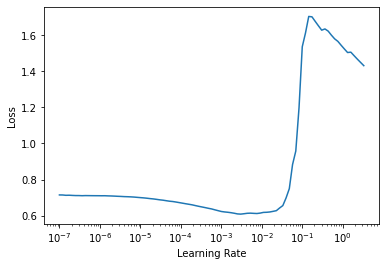

In [65]:
learn.lr_find()

In [66]:
learn.fit_one_cycle(5,0.0005)

epoch,train_loss,valid_loss,accuracy,time
0,0.677264,0.678870,0.582425,00:03
1,0.632663,0.680494,0.580500,00:03
2,0.587033,0.733359,0.576010,00:03
3,0.542081,0.704846,0.574086,00:03
4,0.503807,0.684017,0.579217,00:03


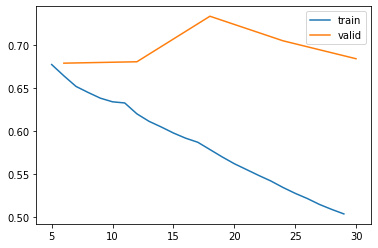

In [67]:
learn.recorder.plot_loss()

In [68]:
preds,targs = learn.get_preds()

In [78]:
np.argmax(preds, 1)

tensor([0, 0, 1,  ..., 1, 0, 0])

In [80]:
accuracy_score(targs,np.argmax(preds, 1))

0.5792174470814625

In [ ]:
## Model - team based - similar opponents as training data
获取球队最近几场与相似对手交手时，取得的数据作为training data

相似对手：

1. 将ortg和drtg作为x轴y轴，几何距离最近的对手

1. 用什么的ortg，drtg？所有本赛季已进行的比赛的数据？单场？

In [ ]:
## Model - Player based

In [ ]:
# players? -> include minutes played
# injured players?
# use news to guess how many minutes he will play